In [2]:
using Distributions
using LinearAlgebra
using Statistics
using Dates
using DataFrames
using Plots
import CSV
using JSON
try
    using Revise
catch e
    @warn "Error initializing Revise" exception=(e, catch_backtrace())
end
includet(pwd() * "\\Water_Regulation\\WaterRegulation.jl")
using .WaterRegulation

### Example of Water Regulation 

In this notebook we exemplify the day-to-day activities of the water regulation company.  
For that we generate 1-2 simple reservoir systems, in which power producers nominate for discharge at different reservoirs.  
Concepts such as the adjusted flow, power swap, reduction through spillage should be readily apparent after working through the examples.  
We also visualize what happens if we change our nomination: When does spillage happen, how does the adjusted flow change, how does it affect the power swap, how does it affect the amount of power we can produce?  
Something else to consider is how we can calculate the reference flow. Maybe do this in this file, or in another file where we work more closely with the real water data.

In [3]:
filepath_Ljungan = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\Ljungan.json"
filepath_prices = pwd() *  "\\Data\\Spot Prices\\prices_df.csv"
filepath_results = pwd() * "\\Results\\LambdaZero\\"
R, K, J = read_data(filepath_Ljungan)
print() 

j = J[1]
K_j = j.plants
O, K_O = OtherParticipant(J, j, R)
pj = j.participationrate
pO = O.participationrate


println("Participation rate $(j.name): \n ", pj)
println("Participation rate $(O.name): \n ", pO)
println("K_O : $(K_O) and spillage $(K_O[1].spillreference),\nK_j : $(K_j) and spillage $(K_j[1].spillreference)")

Participation rate Sydkraft: 
 ________________________________
Flasjon  | 1.84    
Holsmjon | 0.0     

Participation rate Other: 
 ________________________________
Flasjon  | 2.68    
Holsmjon | 2.68    



K_O : HydropowerPlant[Parteboda, Hermansboda, Ljunga, Nederede, Skallbole, Matfors, Viforsen, Jarnvagsforsen] and spillage 1.4,
K_j : HydropowerPlant[Flasjo, Trangfors, Ratan, Turinge, Bursnas] and spillage 0.58


In [4]:
filepath_Simple = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\SimpleReservoirSystem.json"
R1, K1, J1 = read_data(filepath_Simple)

println("The reservoir system is made up of the following components: \n ______________________________________________________")
println("Reservoirs: ", [r.dischargepoint for r in R1])
for r in R1
    println("The reservoir $(r.dischargepoint) has a maximum capacity of $(r.maxvolume).")
end
println("Power Plants: ", [k.name for k in K1])
println("The power plants have the following production capacities until there is spillage: ")
for k in K1
    println("$(k.name) has spillage upper bound of $(k.spillreference). Additionally, the equivalent is $(k.equivalent), thus the maximum power is $(k.equivalent * k.spillreference)")
end
println("Participants: ", [p.name for p in J1])
println("The Participants are owners of the following power plants: ")
for j in J1
    println("$(j.name) is owner of $([k.name for k in j.plants]). Because of this ownership the participationrate becomes \n $(j.participationrate)")
end

The reservoir system is made up of the following components: 
 ______________________________________________________


Reservoirs: 

["A"]
The reservoir A has a maximum capacity of 9000.0.


Power Plants: ["Kraftwerk1", "

Kraftwerk2", "Kraftwerk3"]
The power plants have the following production capacities until there is spillage: 
Kraftwerk1 has spillage upper bound of 1.0. Additionally, the equivalent is 0.4, thus the maximum power is 0.4


Kraftwerk2 has spillage upper bound of 1.2. Additionally, the equivalent is 0.7, thus the maximum power is 0.84
Kraftwerk3 has spillage upper bound of 1.3. Additionally, the equivalent is 0.3, thus the maximum power is 0.39
Participants: 

["EON", "RWE", "Statkraft"]
The Participants are owners of the following power plants: 


EON is owner of ["Kraftwerk1"]. Because of this ownership the participationrate becomes 
 ________________________________
A        | 0.4     

RWE is owner of ["Kraftwerk2"]. Because of this ownership the participationrate becomes 
 ________________________________
A        | 0.7     

Statkraft is owner of ["Kraftwerk3"]. Because of this ownership the participationrate becomes 
 ________________________________
A        | 0.3     



We assume prices are high and and all producers want to produce at maximum capacity.

In [19]:
Nomination = Dict{NamedTuple{(:participant, :reservoir), Tuple{Participant, Reservoir}}, Float64}((participant = j, reservoir = r) => 0.0 for j in J1 for r in R1)
Nomination[(participant = J1[1], reservoir = R1[1])] = 1.0
Nomination[(participant = J1[2], reservoir = R1[1])] = 0.6
Nomination[(participant = J1[3], reservoir = R1[1])] = 0.8
Qref = Dict{Reservoir, Float64}(r => 0.8 for r in R1)
T = 24

Qadj, QadjTot, P_Swap, POver, ΣPOver, MaxEnergy = water_regulation(Nomination, Qref, T);
println("The Nominations are as following: ", Nomination)
println("The adjusted flow is: ", Qadj)

function Nomination_Variation(j::Participant, r::Reservoir, Noms::Dict{NamedTuple{(:participant, :reservoir), Tuple{Participant, Reservoir}}, Float64}, NomRange, Qref::Dict{Reservoir, Float64}; T = 24)
    Qadjs::Vector{Float64} = []
    P_Swaps::Vector{Float64} = []
    for nom in NomRange
        Noms[(participant = j, reservoir = r)] = nom
        Qadj_loc, _,P_Swap_loc,_,_,_ = water_regulation(Noms, Qref, T);
        println("The adjusted flow is: ", Qadj_loc[r])
        println("The Power Swap bacomes: ", P_Swap_loc[j][r])
        push!(Qadjs, Qadj_loc[r])
        push!(P_Swaps, P_Swap_loc[j][r])
    end
    return Qadjs, P_Swaps
end

The Nominations are as following: Dict{NamedTuple{(:participant, :reservoir), Tuple{Participant, Reservoir}}, Float64}((participant = RWE, reservoir = A) => 1.2, (participant = EON, reservoir = A) => 1.0, (participant = Statkraft, reservoir = A) => 1.3)
The adjusted flow is: ________________________________
A        | 1.1642857142857141



Nomination_Variation (generic function with 2 methods)

### Visualize the adjusted Flow and Nominations

What if keep the nomination fixed for two of the producers, and change one nomination?  
* How does the adjusted flow change?
* How does the Power Swap change? When is the overnomination a limiting factor?
* How does this change for the different producers?

The adjusted flow is: 0.8785714285714284


The Power Swap bacomes: -0.3514285714285714
The adjusted flow is: 0.907142857142857
The Power Swap bacomes: -0.32285714285714284
The adjusted flow is: 0.9357142857142856
The Power Swap bacomes: -0.2942857142857142
The adjusted flow is: 0.9642857142857143
The Power Swap bacomes: -0.26571428571428574
The adjusted flow is: 0.9928571428571429
The Power Swap bacomes: -0.23714285714285716
The adjusted flow is: 1.0214285714285714
The Power Swap bacomes: -0.2
The adjusted flow is: 1.05
The Power Swap bacomes: -0.16000000000000003
The adjusted flow is: 1.0785714285714283


The Power Swap bacomes: -0.12000000000000004
The adjusted flow is: 1.1071428571428572
The Power Swap bacomes: -0.07999999999999999
The adjusted flow is: 1.1357142857142855
The Power Swap bacomes: -0.039999999999999994
The adjusted flow is: 1.1642857142857141
The Power Swap bacomes: 0.0
The adjusted flow is: 1.1928571428571426
The Power Swap bacomes: 1.0408340855860843e-16
The adjusted flow is: 1.2214285714285713
The Power Swap bacomes: 3.8163916471489756e-17
The adjusted flow is: 1.2499999999999998
The Power Swap bacomes: 1.8041124150158794e-16
The adjusted flow is: 1.2785714285714285
The Power Swap bacomes: 0.008571428571428626
The adjusted flow is: 1.3071428571428572
The Power Swap bacomes: 0.015
The adjusted flow is: 1.3357142857142856
The Power Swap bacomes: 0.015000000000000138
The adjusted flow is: 1.3642857142857143
The Power Swap bacomes: 0.015
The adjusted flow is: 1.3928571428571428
The Power Swap bacomes: 0.015000000000000124
The adjusted flow is: 1.4214285714285715
The Pow

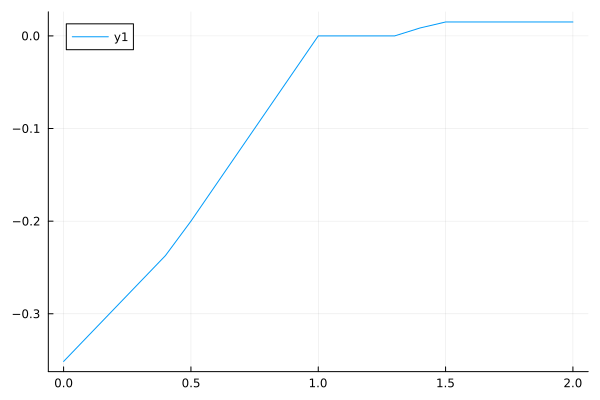

In [20]:
noms = 0:0.1:2

Qadjs, P_Swaps = Nomination_Variation(J1[1], R1[1], Nomination, noms, Qref)


Plots.plot(noms, Qadjs)
Plots.plot(noms, P_Swaps)